## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [3]:
path = Path('./SegNet-Tutorial/CamVid')

In [4]:
path.ls()

[PosixPath('SegNet-Tutorial/CamVid/val'),
 PosixPath('SegNet-Tutorial/CamVid/train'),
 PosixPath('SegNet-Tutorial/CamVid/models'),
 PosixPath('SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('SegNet-Tutorial/CamVid/test'),
 PosixPath('SegNet-Tutorial/CamVid/valannot'),
 PosixPath('SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('SegNet-Tutorial/CamVid/testannot')]

## Data

In [5]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08113.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08067.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08081.png')]

In [6]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08113.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08067.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08081.png')]

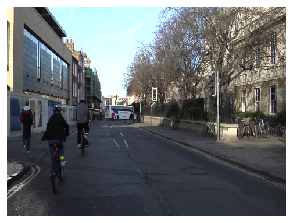

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name # returns path to annotated image

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

In [9]:
x = img_f
x.name, x.stem, x.suffix, x.parent

('0016E5_08113.png',
 '0016E5_08113',
 '.png',
 PosixPath('SegNet-Tutorial/CamVid/val'))

In [10]:
# from matplotlib import pyplot
# from PIL import Image
# pyplot.imshow(Image.open(str(get_y_fn(img_f))))

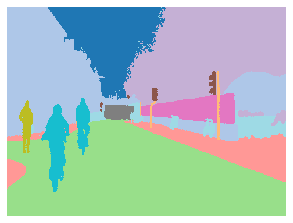

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

## Datasets

In [13]:
bs,size = 8,src_size//2

In [14]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [20]:
data = (src.transform(get_transforms(), tfm_y=True, size=size) # note that we're passing size, ,so reducing the img size!
        .databunch(bs=bs)
        .normalize(imagenet_stats))

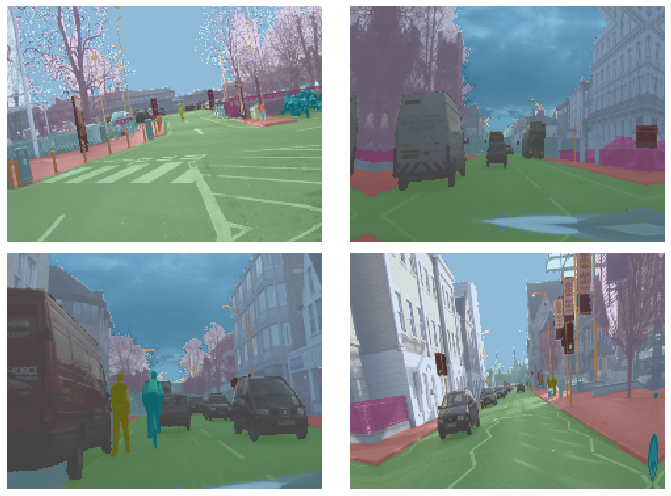

In [18]:
data.show_batch(2, figsize=(10,7))

## Model

In [15]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

# define the metric we're going to use - check on non-void parts of the image if we correctly classified the pixel
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [16]:
metrics=acc_camvid
wd=1e-2

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


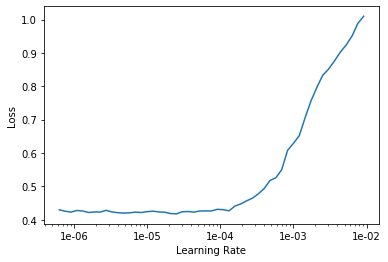

In [28]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr=1e-4
doc(learn.fit_one_cycle)

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [26]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [27]:
learn.unfreeze()

In [29]:
lrs = slice(lr/100,lr/10) # see plot above ( I re-run the rl_find() there )

In [30]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

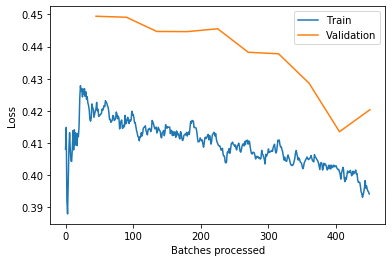

In [32]:
learn.recorder.plot_losses()

In [33]:
learn.fit_one_cycle(5, lrs, pct_start=0.8)

In [35]:
learn.save('stage-2');

## Go big
Remeber the objective is to segment the whole image, not only the half-sized one

In [17]:
learn=None
gc.collect()

4582

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`. (Remember to re-run cells up to the dataset section [up to cell 14 + cell 17-18])

In [22]:
size = src_size
bs=2 # upscaled images 4 times, need to reduce bs 4 times....

In [19]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

metrics=acc_camvid
wd=1e-2

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


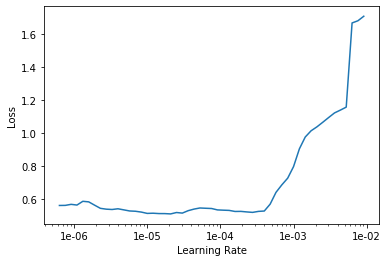

In [21]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr=1e-5

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [25]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [26]:
learn.unfreeze()

In [27]:
lrs = slice(lr/1000,lr/10)

In [28]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

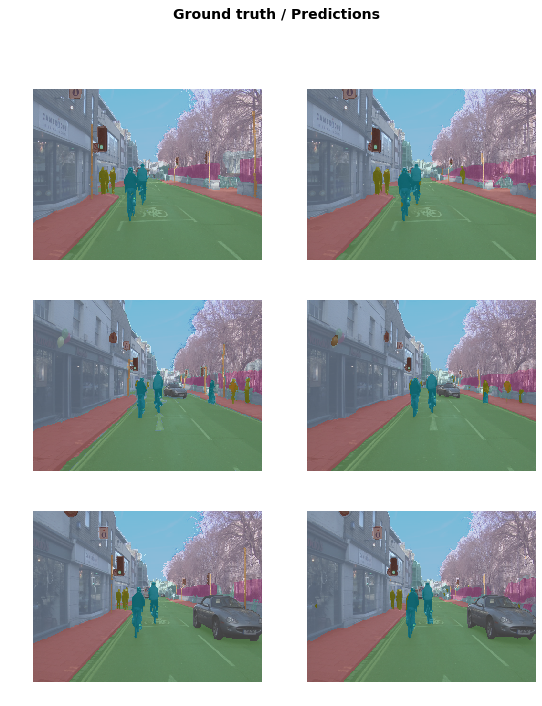

In [ ]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [ ]:
# start: 480x360

In [ ]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 64, 180, 240]    9408       False     
______________________________________________________________________
BatchNorm2d          [8, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [8, 64, 180, 240]    0          False     
______________________________________________________________________
MaxPool2d            [8, 64, 90, 120]     0          False     
______________________________________________________________________
Conv2d               [8, 64, 90, 120]     36864      False     
______________________________________________________________________
BatchNorm2d          [8, 64, 90, 120]     128        True      
______________________________________________________________________
ReLU                 [8, 64, 90, 120]     0          False     
______________________________________________________________